In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import os
import math
import datetime
import matplotlib.pyplot as plt 
import scipy.stats as sstats
from scipy.stats.sampling import DiscreteAliasUrn
from matplotlib import cm
import random
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import numpy
%matplotlib inline 
from matplotlib import pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import IPython.display
import json
import sys
import yaml
from random import randrange
from functions_gapfill import *


In [2]:
# we want to introdce 10% missing data at locations X and 
# 24, 48,72,96

# Gapfilling the AWS of the LéXPLORE platform

In this notebook we use the G2S server with Direct Sampling approach (https://gaia-unil.github.io/G2S/briefOverview.html) to fill the data gaps of the meteo station or AWS of the LéXPLORE platform (https://gitlab.renkulab.io/lexplore).

See other notebooks in this repository on how to arrive at this point. 

We use already 1 hourly aggregated values of the meteo station and we fill gaps for the following variables on 1 hour resolution:

* Air temperature

* Baromatric pressure 

* Relative Humidity

* Wind Speed

* Wind Direction

* Wind Gusts

* Precipitation

* Solar Incoming Radiation 

* Solar Total Incoming Radation (PROBABLY NOT)

To do so, we use independent data as co-variates, namely variables from the closest gridpoint in ERA5 and ERA5-land. Other potential co-variates could be AWS data from other locations around Lake Geneva or data from other weather models or reconstructions. 

## Activate G2S server

In [3]:
#!pip install G2S libtiff --quiet
from g2s import g2s
g2s('--version')


G2S version 0.98.015, compiled the Dec 17 2022 16:39:25 with Python 3.11.1


In [4]:
#! git clone https://github.com/GAIA-UNIL/G2S.git --quiet

In [5]:
#%%capture
#!export NVFLAGS='-gencode=arch=compute_35,code=sm_35 -gencode=arch=compute_37,code=sm_37 -gencode=arch=compute_50,code=sm_50 -gencode=arch=compute_52,code=sm_52 -gencode=arch=compute_60,code=sm_60 -gencode=arch=compute_61,code=sm_61 -gencode=arch=compute_70,code=sm_70 -gencode=arch=compute_70,code=compute_70'
#!sudo apt -qq install build-essential libzmq3-dev libjsoncpp-dev zlib1g-dev libfftw3-dev libcurl4-openssl-dev -y
#!sudo wget -q "https://raw.githubusercontent.com/zeromq/cppzmq/master/zmq.hpp" -O /usr/include/zmq.hpp
#!( cd G2S/build && make c++ -j --silent)
#!bash G2S/build/c++-build/install_needs_W_VM.sh

In [6]:
!pwd

/home/mwegmann/g2s/notebooks


In [7]:
os.chdir("/home/mwegmann/g2s")

In [8]:
!bash -c "cd G2S/build/c++-build/ && ./server -d"


start daemon


In [9]:
ti = numpy.array(Image.open(BytesIO(requests.get('https://raw.githubusercontent.com/GAIA-UNIL/TrainingImagesTIFF/master/stone.tiff').content)));

In [10]:
a=g2s('-a','echo','-ti',ti,'-dt',[0])

job Id is: 2364164698
progress 100.000%      
        

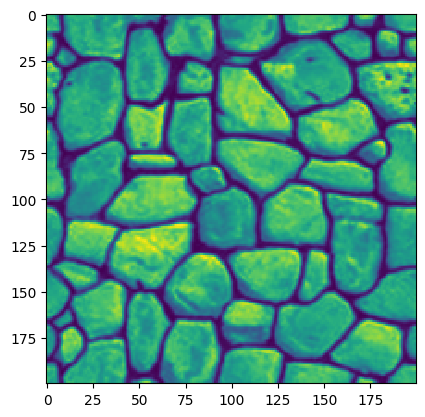

In [11]:
plt.imshow(a[0], interpolation='nearest')

## folder setup

In [12]:
# change yaml location here
with open(r"/home/mwegmann/g2s/notebooks/folder_gap_filling.yaml", "r") as f:
    directories = yaml.load(f, Loader=yaml.FullLoader)

In [13]:
#for d in directories.values():
#    if not os.path.exists(d):
#        os.makedirs(d)

In [14]:
# defining folders
input_folder=directories["g2s_input_folder"]

output_folder=directories["g2s_output_folder"]

scripts_folder=directories["scripts_folder"]

## Direct Sampling Coefficients

In [15]:
amount_member=50
test_runs=5

## read in data

In [16]:
meteo_orig=xr.open_dataset(input_folder+"meteo_1hr_g2s.nc")

In [17]:
meteo_orig

<xarray.Dataset>
Dimensions:   (time: 26280)
Coordinates:
  * time      (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    AirTC     (time) float64 ...
    RH        (time) float64 ...
    Slrw      (time) float64 ...
    WS        (time) float64 ...
    WindDir   (time) float64 ...
    Rain      (time) float64 ...
    BP        (time) float64 ...
    WindGust  (time) float64 ...

In [18]:
era5=xr.open_dataset(input_folder+"era5_lexplore_g2s.nc")

In [19]:
era5

<xarray.Dataset>
Dimensions:    (time: 26280)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * time       (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    u10        (time) float32 ...
    v10        (time) float32 ...
    t2m        (time) float32 ...
    sp         (time) float32 ...
    ssrd       (time) float32 ...
    tp         (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-05 18:55:56 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [20]:
era5_land=xr.open_dataset(input_folder+"era5_land_lexplore_g2s.nc")

In [21]:
era5_land

<xarray.Dataset>
Dimensions:    (time: 26280)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * time       (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    sp         (time) float32 ...
    ssrd       (time) float32 ...
    t2m        (time) float32 ...
    tp         (time) float32 ...
    u10        (time) float32 ...
    v10        (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-13 10:24:45 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Fill Air Temperature Data

### understand the average gap size in data

In [22]:
meteo_orig_airtc = meteo_orig.AirTC


In [23]:
compute_gap_sizes(meteo_orig_airtc)

array([ 48,  24,  72,  24, 156,  48,  96,  24,  24,  72, 168,   1,  96,
        16,   4,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1])

meteo_orig_airtc has 931 nans in 26280 data points
meteo_orig_airtc has 3.5426179604261794% missing values
meteo_orig_airtc has 73 gaps with 1.0 median gap size
meteo_orig_airtc has 73 gaps with 12.753424657534246 mean gap size


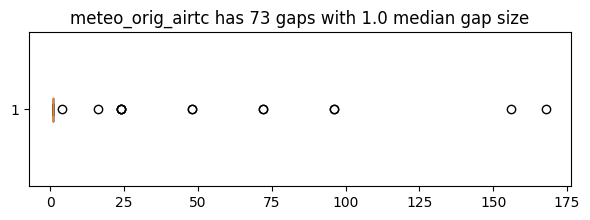

In [24]:
gap_info(meteo_orig_airtc, "meteo_orig_airtc")

In [25]:
np.isnan(meteo_orig_airtc.values).sum()

931

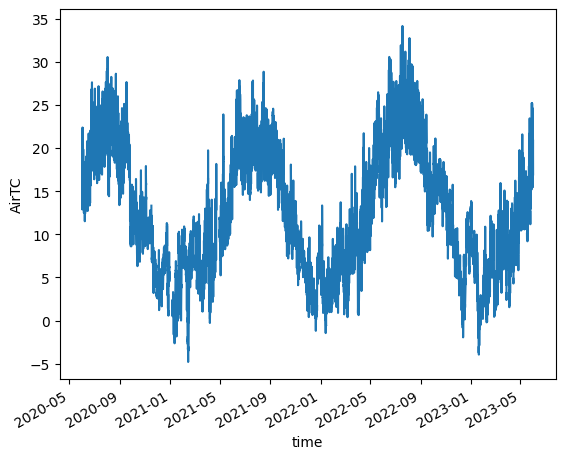

In [26]:
meteo_orig_airtc.plot()

### create replicable gaps

The idea is to create gaps that are always at the same position, but different in size.

It is tricky to think about a "perfect gap size" that we should try out. I would suggest that we try out gap sizes from 1 day (24 missing values in the case of the meteo station) towards 4 days (96 missing values in case of the meteo station).

The other question is how many (in %) new missing values do we introduce to evaluate our routine. The meteo station has 3% missing data as it is. Is 10% a good metric to evaluate? 20%?

In [27]:
gap_sizes = compute_gap_sizes(meteo_orig_airtc) #number and size of gaps
gap_sizes

array([ 48,  24,  72,  24, 156,  48,  96,  24,  24,  72, 168,   1,  96,
        16,   4,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1])

In [28]:
gap_sizes[gap_sizes>24] = 24
gap_sizes

array([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,  1, 24, 16,  4,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1])

In [29]:
#new_var=meteo_orig_airtc.copy()
#da=new_var.copy()

In [30]:
gap_locations=create_gap_index(da=meteo_orig_airtc,gap_percent=5,gap_length=24)

In [31]:
meteo_gapped_airtc_24_5=create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=24,selector=1)

Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :2212
% NAs in new :8.417047184170471
Added % NAs :4.874429223744292


In [32]:
meteo_gapped_airtc_48_5=create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=48,selector=2)

Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :2212
% NAs in new :8.417047184170471
Added % NAs :4.874429223744292


In [33]:
meteo_gapped_airtc_72_5=create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=72,selector=3)

Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :2205
% NAs in new :8.39041095890411
Added % NAs :4.847792998477931


In [34]:
meteo_gapped_airtc_96_5=create_gapped_ts(da=meteo_orig_airtc,gap_locations=gap_locations,gap_length=96,selector=4)

Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :2192
% NAs in new :8.340943683409437
Added % NAs :4.798325722983257


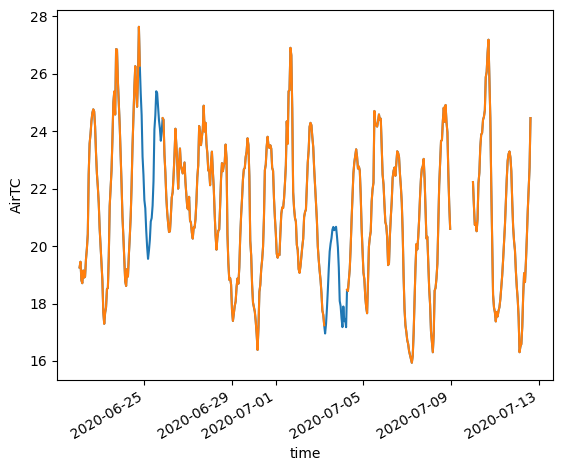

In [35]:

meteo_orig_airtc[505:1000].plot()
meteo_gapped_airtc_24_5[505:1000].plot()


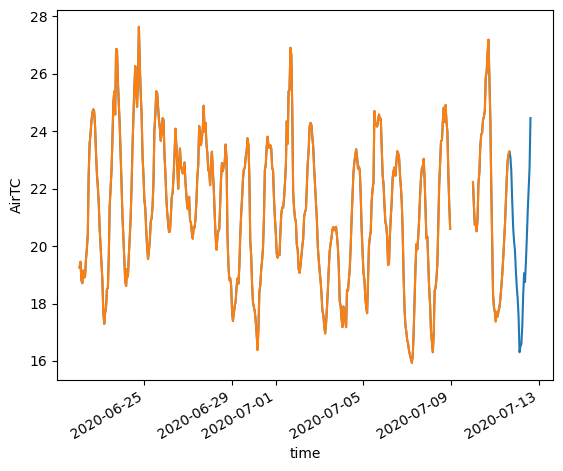

In [36]:

meteo_orig_airtc[505:1000].plot()
meteo_gapped_airtc_72_5[505:1000].plot()


## Run gapfilling

In [37]:
percent_list=[5,10,15]
gap_amount_list=[24,48,72,96]
selector_list=[1,2,3,4]
#gap_amount_list=[150]
N = amount_member
runs=test_runs


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","RMSE","STDR"]

df = pd.DataFrame(columns=columns_df)

In [38]:
print(datetime.datetime.now())

2023-08-30 13:39:43.525795


In [39]:
filled_data,error_df=univ_g2s(original=meteo_orig,var="AirTC",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo")

metrics saved to: /home/mwegmann/g2s/output_data//meteoAirTC.csv
Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :2200
% NAs in new :8.37138508371385
Added % NAs :4.828767123287672
This is run 1 with N=50 added missing % is 5 and Gap size is 24
job Id is: 3071561767
progress 100.000%       
        job Id is: 3211459047
progress 100.000%       
        job Id is: 296282843
progress 100.000%       
        job Id is: 435816345
progress 100.000%       
        job Id is: 595665030
progress 100.000%       
        job Id is: 2252063639
progress 100.000%       
        job Id is: 3007063131
progress 100.000%       
        job Id is: 85300291
progress 100.000%       
        job Id is: 843641185
progress 100.000%       
        job Id is: 4033479764
progress 100.000%       
        job Id is: 3555324354
progress 100.000%       
        job Id is: 3087146651
progress 100.000%       
        job Id is: 1984248126
progress 100.000%       
        job Id is: 1499807

progress 100.000%       
        job Id is: 2543222804
progress 100.000%       
        job Id is: 1443746308
progress 100.000%       
        job Id is: 1570930750
progress 100.000%       
        job Id is: 1083730437
progress 100.000%       
        job Id is: 603930921
progress 100.000%       
        job Id is: 120922092
progress 100.000%       
        job Id is: 244643091
progress 100.000%       
        job Id is: 4059217022
progress 100.000%       
        job Id is: 3725414233
progress 100.000%       
        job Id is: 3263502690
progress 100.000%       
        job Id is: 2163642754
progress 100.000%       
        job Id is: 1709781914
progress 100.000%       
        Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :2275
% NAs in new :8.656773211567732
Added % NAs :5.114155251141553
This is run 1 with N=50 added missing % is 5 and Gap size is 96
job Id is: 1507118004
progress 100.000%       
        job Id is: 1045613771
progress 100.000%       

progress 100.000%       
        job Id is: 2959876524
progress 100.000%       
        job Id is: 3743793378
progress 100.000%       
        job Id is: 242206540
progress 100.000%       
        job Id is: 421104414
progress 100.000%       
        job Id is: 1202635720
progress 100.000%       
        job Id is: 1368322499
progress 100.000%       
        job Id is: 2169041781
progress 100.000%       
        job Id is: 2957447090
progress 100.000%       
        job Id is: 3752338132
progress 100.000%       
        job Id is: 259572564
progress 100.000%       
        job Id is: 1038714773
progress 100.000%       
        job Id is: 1818359558
progress 100.000%       
        job Id is: 2596941986
progress 100.000%       
        job Id is: 3382239051
progress 100.000%       
        job Id is: 4142214243
progress 100.000%       
        job Id is: 624308265
progress 100.000%       
        job Id is: 1415017068
progress 100.000%       
        job Id is: 2199569073
progress 100.0

progress 100.000%       
        job Id is: 2332661513
progress 100.000%       
        job Id is: 27948741
progress 100.000%       
        job Id is: 2625454388
progress 100.000%       
        job Id is: 1541431371
progress 100.000%       
        job Id is: 4145661928
progress 100.000%       
        job Id is: 1841266846
progress 100.000%       
        Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :2290
% NAs in new :8.713850837138509
Added % NAs :5.171232876712329
This is run 2 with N=50 added missing % is 5 and Gap size is 72
job Id is: 363405298
progress 100.000%       
        job Id is: 2960959614
progress 100.000%       
        job Id is: 1272018337
progress 100.000%       
        job Id is: 2231061199
progress 100.000%       
        job Id is: 1147431703
progress 100.000%       
        job Id is: 3748917290
progress 100.000%       
        job Id is: 2055954281
progress 100.000%       
        job Id is: 361637713
progress 100.000%       


progress 100.000%       
        job Id is: 2668797459
progress 100.000%       
        job Id is: 1594342252
progress 100.000%       
        job Id is: 516863144
progress 100.000%       
        job Id is: 63547238
progress 100.000%       
        job Id is: 3276148517
progress 100.000%       
        job Id is: 2200127191
progress 100.000%       
        job Id is: 1134926856
progress 100.000%       
        job Id is: 71385221
progress 100.000%       
        job Id is: 3297913187
progress 100.000%       
        job Id is: 2222684953
progress 100.000%       
        job Id is: 1770251234
progress 100.000%       
        job Id is: 692640918
progress 100.000%       
        job Id is: 236840307
progress 100.000%       
        job Id is: 4074670494
progress 100.000%       
        job Id is: 3011088489
progress 100.000%       
        job Id is: 1945190810
progress 100.000%       
        job Id is: 869933926
progress 100.000%       
        job Id is: 411272108
progress 100.000%  

progress 100.000%       
        Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :2192
% NAs in new :8.340943683409437
Added % NAs :4.798325722983257
This is run 3 with N=50 added missing % is 5 and Gap size is 48
job Id is: 3501744386
progress 100.000%       
        job Id is: 1801907997
progress 100.000%       
        job Id is: 3789287615
progress 100.000%       
        job Id is: 2106029461
progress 100.000%       
        job Id is: 401515057
progress 100.000%       
        job Id is: 2387905998
progress 100.000%       
        job Id is: 693630100
progress 100.000%       
        job Id is: 2681676609
progress 100.000%       
        job Id is: 981646128
progress 100.000%       
        job Id is: 2964773543
progress 100.000%       
        job Id is: 1259509651
progress 100.000%       
        job Id is: 3244787963
progress 100.000%       
        job Id is: 939299087
progress 100.000%       
        job Id is: 2919517487
progress 100.000%       


progress 100.000%       
        job Id is: 895531881
progress 100.000%       
        job Id is: 439288780
progress 100.000%       
        job Id is: 602087994
progress 100.000%       
        job Id is: 144580144
progress 100.000%       
        job Id is: 3991299046
progress 100.000%       
        job Id is: 3529051324
progress 100.000%       
        job Id is: 3081808499
progress 100.000%       
        job Id is: 2613058465
progress 100.000%       
        job Id is: 2767402583
progress 100.000%       
        job Id is: 2935663760
progress 100.000%       
        job Id is: 2475851117
progress 100.000%       
        job Id is: 2630424703
progress 100.000%       
        job Id is: 2187143141
progress 100.000%       
        job Id is: 1730981954
progress 100.000%       
        job Id is: 1863245925
progress 100.000%       
        job Id is: 1383253379
progress 100.000%       
        job Id is: 930582807
progress 100.000%       
        job Id is: 473993412
progress 100.000

progress 100.000%       
        job Id is: 2078045000
progress 100.000%       
        job Id is: 379437545
progress 100.000%       
        job Id is: 2983022881
progress 100.000%       
        job Id is: 1281774422
progress 100.000%       
        job Id is: 199884804
progress 100.000%       
        job Id is: 2799587153
progress 100.000%       
        job Id is: 1110529303
progress 100.000%       
        job Id is: 3723140151
progress 100.000%       
        job Id is: 2016271759
progress 100.000%       
        job Id is: 317520852
progress 100.000%       
        job Id is: 2929704489
progress 100.000%       
        job Id is: 626485266
progress 100.000%       
        job Id is: 3224986640
progress 100.000%       
        job Id is: 1525377052
progress 100.000%       
        job Id is: 4121630249
progress 100.000%       
        job Id is: 2420869200
progress 100.000%       
        job Id is: 716667691
progress 100.000%       
        job Id is: 3317473142
progress 100.00

progress 100.000%       
        job Id is: 3039591719
progress 100.000%       
        job Id is: 1349237596
progress 100.000%       
        job Id is: 3962838329
progress 100.000%       
        job Id is: 2272608404
progress 100.000%       
        job Id is: 1206740904
progress 100.000%       
        job Id is: 3803013944
progress 100.000%       
        Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :2213
% NAs in new :8.420852359208524
Added % NAs :4.878234398782344
This is run 4 with N=50 added missing % is 5 and Gap size is 96
job Id is: 2227955496
progress 100.000%       
        job Id is: 543974149
progress 100.000%       
        job Id is: 3134558897
progress 100.000%       
        job Id is: 2058965711
progress 100.000%       
        job Id is: 367708940
progress 100.000%       
        job Id is: 3584489741
progress 100.000%       
        job Id is: 2506049664
progress 100.000%       
        job Id is: 804238743
progress 100.000%       

progress 100.000%       
        job Id is: 2938178142
progress 100.000%       
        job Id is: 3093046914
progress 100.000%       
        job Id is: 3262882559
progress 100.000%       
        job Id is: 3428858928
progress 100.000%       
        job Id is: 2981695568
progress 100.000%       
        job Id is: 3154842172
progress 100.000%       
        job Id is: 3332520381
progress 100.000%       
        job Id is: 3492352584
progress 100.000%       
        job Id is: 3647804455
progress 100.000%       
        job Id is: 3816070170
progress 100.000%       
        job Id is: 3984661858
progress 100.000%       
        job Id is: 3526923249
progress 100.000%       
        job Id is: 3685801040
progress 100.000%       
        job Id is: 3235674972
progress 100.000%       
        job Id is: 3407581401
progress 100.000%       
        job Id is: 4188923062
progress 100.000%       
        job Id is: 52948798
progress 100.000%       
        job Id is: 3904304409
progress 100

progress 100.000%       
        Amount NAs in orig :931
% NAs in orig :3.5426179604261794
Amount NAs in new :2293
% NAs in new :8.725266362252663
Added % NAs :5.182648401826484
This is run 5 with N=50 added missing % is 5 and Gap size is 72
job Id is: 1211835055
progress 100.000%       
        job Id is: 3808849558
progress 100.000%       
        job Id is: 2110219922
progress 100.000%       
        job Id is: 417565792
progress 100.000%       
        job Id is: 2405454253
progress 100.000%       
        job Id is: 716913292
progress 100.000%       
        job Id is: 3937547155
progress 100.000%       
        job Id is: 2238135903
progress 100.000%       
        job Id is: 536117401
progress 100.000%       
        job Id is: 3132271498
progress 100.000%       
        job Id is: 1434245386
progress 100.000%       
        job Id is: 4031654580
progress 100.000%       
        job Id is: 1724561981
progress 100.000%       
        job Id is: 32842186
progress 100.000%       
 

progress 100.000%       
        job Id is: 788804192
progress 100.000%       
        job Id is: 330994343
progress 100.000%       
        job Id is: 3536889495
progress 100.000%       
        job Id is: 4292060436
progress 100.000%       
        job Id is: 119771475
progress 100.000%       
        job Id is: 3962925586
progress 100.000%       
        job Id is: 2886452022
progress 100.000%       
        job Id is: 1806459878
progress 100.000%       
        job Id is: 734145270
progress 100.000%       
        job Id is: 3954115756
progress 100.000%       
        job Id is: 3497851989
progress 100.000%       
        job Id is: 2425873495
progress 100.000%       
        job Id is: 1366461039
progress 100.000%       
        job Id is: 880142441
progress 100.000%       
        job Id is: 4095955735
progress 100.000%       
        job Id is: 3029961134
progress 100.000%       
        job Id is: 1955049929
progress 100.000%       
        job Id is: 891238830
progress 100.000

In [40]:
error_df

,NAME,RUN,MEMBER,PERC,GAP_SIZE,CORR,RMSE,STDR
0,UV,1,50,5,24,0.9980,0.4443,0.9990
0,UV,1,50,5,48,0.9959,0.6435,1.0013
0,UV,1,50,5,72,0.9936,0.7990,0.9953
0,UV,1,50,5,96,0.9926,0.8584,0.9940
0,UV,1,50,10,24,0.9967,0.5779,1.0005
0,UV,1,50,10,48,0.9891,1.0490,1.0319
0,UV,1,50,10,72,0.9871,1.1336,0.9926
0,UV,1,50,10,96,0.9861,1.1819,1.0351
0,UV,1,50,15,24,0.9944,0.7498,0.9987
0,UV,1,50,15,48,0.9846,1.2345,1.0019


In [41]:
print(datetime.datetime.now())

2023-08-30 16:51:26.158741
